# Instagram’s Public JSON APIs
**Just by adding ‘?__a=1’ at end**

<font color=green>https://www.instagram.com/_USER_NAME_/?__a=1</font>

In [1]:
import requests
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt


userName = '__INSERT_INSTAGRAM__USERNAME__'
jsonData = json.loads(requests.get("https://www.instagram.com/%s?__a=1" % userName).text)
numOfMedia = len(jsonData['graphql']['user']['edge_owner_to_timeline_media']['edges'])

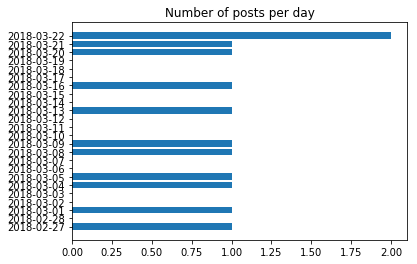

In [2]:
#read instagram user published images from this JSON string
medias = jsonData['graphql']['user']['edge_owner_to_timeline_media']['edges']

publishMedia = []

for mediaNode in medias:
    #convert UNIX timestamp into date and hour
    publishDate = datetime.datetime.fromtimestamp(int(mediaNode['node']['taken_at_timestamp'])).strftime('%Y-%m-%d')
    publishHour = datetime.datetime.fromtimestamp(int(mediaNode['node']['taken_at_timestamp'])).strftime('%H')
    #number of likes for each picture
    edgeLikes = int(mediaNode['node']['edge_liked_by']['count'])
    publishMedia.append((publishDate, publishHour, edgeLikes))
    
#convert to dataFrame    
df = pd.DataFrame(publishMedia, columns = ['publishDate', 'publishHour', 'edgeLikes'])
#group dataset by date and count
gd = df.groupby(df.publishDate).size().reset_index(name='counts')

#DataIndeRange with all dates from dataset min to max date
days = pd.date_range(df.publishDate.min(), df.publishDate.max(), name='publishDate').strftime('%Y-%m-%d') 
dDates = pd.DataFrame(days, columns = ['publishDate'])

#merge two dataFrame
result = dDates.merge(gd, how='outer')

#plot result i horizontal graph
plt.barh(result.publishDate, result.counts)
plt.title('Number of posts per day')
plt.show()



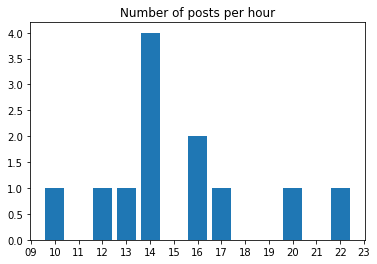

In [3]:
#group dataset by hour and count
pHour = df.groupby(df.publishHour).size().reset_index(name='counts')

#List hours from 0 to 23
hours = [(datetime.time(i).strftime('%H')) for i in range(24)]
dHours = pd.DataFrame(hours, columns = ['publishHour'])

#merge two dataFrames
plotHourData = dHours.merge(pHour, how='outer')

plt.bar(plotHourData.publishHour, plotHourData.counts)
plt.title('Number of posts per hour')
plt.show()

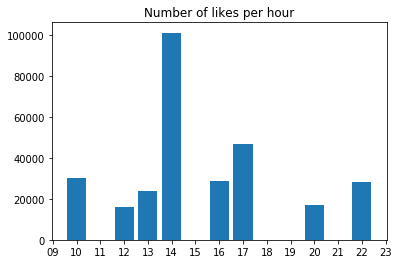

In [4]:
#select only likes and hours from main dataFrame
partData = df.iloc[:,[1,2]]
pLikes = df.groupby([partData.publishHour]).sum().reset_index()

#merge hours with sum of likes
plotLikesData = dHours.merge(pLikes, how='outer')

plt.bar(plotLikesData.publishHour, plotLikesData.edgeLikes)
plt.title('Number of likes per hour')
plt.show()

In [5]:
#more general stats from instagram user
userName = jsonData['graphql']['user']['full_name']
folowedBy = jsonData['graphql']['user']['edge_followed_by']['count']

print(userName)
print('Followed by: %s ' % folowedBy)

publishDayDiff = (pd.to_datetime(df.publishDate).max() - pd.to_datetime(df.publishDate).min()).days + 1
pubFreq = numOfMedia/publishDayDiff
print('Publish frequency per day : %.2f' % pubFreq) 

print('Likes Percentile(75) : %.2f' % df.edgeLikes.quantile(.75))
print('Likes Mean : %.2f' % df.edgeLikes.mean())
print('Likes Min : %s :: Engagement %.2f' % (df.edgeLikes.min(), (df.edgeLikes.min()/int(folowedBy))*100))
print('Likes Max : %s' % df.edgeLikes.max())



Severina Kojic
Followed by: 747189 
Publish frequency per day : 0.50
Likes Percentile(75) : 29215.75
Likes Mean : 24289.92
Likes Min : 8563 :: Engagement 1.15
Likes Max : 46599
